# EX3 - VAE, GAN, WGAN <br>
by: Ariel Kantorovich <br>

In [1]:
!nvidia-smi

Tue Feb 27 13:57:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Import Relevant Librys

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn import svm
from sklearn.metrics import accuracy_score

# Load Cuda device if exist

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Load and transform MNIST Data set

In [3]:
down_flag = False # (Optional) usually false

# # Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()])
# Download and load the training data
train_data = datasets.FashionMNIST('F_MNIST_data', download=down_flag, train=True, transform=transform)
# Download and load the test data
test_data = datasets.FashionMNIST('F_MNIST_data', download=down_flag, train=False, transform=transform)

train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: F_MNIST_data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: F_MNIST_data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
            ))

# Iterating and Visualizing the Dataset

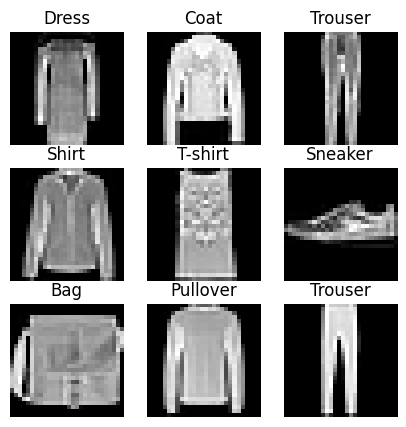

In [4]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (5,5))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

Split to train and valid in addition prepare dataloader for training

In [6]:
# Hyper-parameters
batch_size = 128
valid_size = 0.2
# Data Loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Question 3 - VAE

In [5]:
class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        # Define Parameters
        kernel_size = 3
        padding = 0
        stride = 1
        super().__init__()
        self.model = nn.Sequential(nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding),
                                   nn.BatchNorm2d(out_ch),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
    def forward(self, x):
        return self.model(x)

In [6]:
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        # Define Prameters
        kernel_size = 3
        padding = 1
        stride = 2
        out_pad = 1
        super().__init__()
        self.model = nn.Sequential(nn.ConvTranspose2d(in_ch, out_ch, kernel_size, stride, padding, out_pad),
                                   nn.BatchNorm2d(out_ch),
                                   nn.ReLU())
    def forward(self, x):
        return self.model(x)

In [7]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        # Define Parameters
        IMG_ch = 1
        latent_image_size = 7
        down_ch = (IMG_ch, 32, 64)
        up_ch = down_ch[::-1]
        hidden_dim = 500
        latent_dim = 100
        # Encoder Part:
        self.down_1 = DownBlock(in_ch=down_ch[0], out_ch=down_ch[1])
        self.down_2 = DownBlock(in_ch=down_ch[1], out_ch=down_ch[2])
        # Embedding
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())
        self.embed = nn.Sequential(nn.Linear(in_features=5*5*down_ch[2], out_features=hidden_dim),
                                   nn.ReLU(),
                                   nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
                                   nn.ReLU()
        )
        # Q(Z | X) ~ z, for reprmtirezation trick
        self.mu_fc = nn.Linear(in_features=hidden_dim, out_features=latent_dim)
        self.logvar_fc = nn.Linear(hidden_dim, out_features=latent_dim)

        # Decoder Part
        self.up_0 = nn.Sequential(nn.Linear(in_features=latent_dim, out_features=latent_image_size * latent_image_size * up_ch[0]),
                                  nn.ReLU(),
                                  nn.Unflatten(1, (up_ch[0], latent_image_size, latent_image_size)))
        self.up_1 = UpBlock(in_ch=up_ch[0], out_ch=up_ch[1])
        self.up_2 = UpBlock(in_ch=up_ch[1], out_ch=up_ch[2])

    def forward(self, x):
        # Encoder Part
        x = self.down_1(x)
        x = self.down_2(x)
        x = self.to_vec(x)
        x = self.embed(x)
        # Sampling z ~ Q(Z | X)
        mu = self.mu_fc(x)
        var = self.logvar_fc(x)
        epsilon = torch.rand_like(mu)
        z = mu + var * epsilon # Reparameterization Trick
        # Decoder part
        x = self.up_0(z)
        x = self.up_1(x)
        x = self.up_2(x)
        # Final Activation
        x = torch.sigmoid(x)
        return x, mu, var

Define Loss function: <br>
$$\log p_{\theta}(x) \geq \mathbb{E}_{q_{\phi}(z|x)}[\log p_{\theta}(x|z)] - \text{KL}[q_{\phi}(z|x) || p_{\theta}(z)] = -J(x)$$ where: $\mathbb{E}_{q_{\phi}(z|x)}[\log p_{\theta}(x|z)] = \mathbb{E}_{N(0,I)} \log p_{\theta}(x|\mu_{\phi}(x) + \sigma_{\phi}(x))$

In [8]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='mean')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

Train loop:

In [9]:
def TrainLoop(model, optimizer, NUM_EPOCHS, train_data, test_data, PATH):
    """
    :param model:
    :param optimizer:
    :param NUM_EPOCHS
    :param train_data:
    :param test_data:
    :param PATH:
    :return:
    """
    train_loss_list, test_loss_list = [], []
    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss = 0.0
        for x, _ in train_data:
            x = x.to(device)
            # Zero Optimizer
            optimizer.zero_grad()
            # Forward propgation
            x_hat, mu, var = model(x)
            # Calculate loss
            loss = loss_function(x, x_hat, mu, var)
            train_loss += loss.item()
            # Back Prop
            loss.backward()
            # Update Grad
            optimizer.step()

        # Check Test Error Valid
        model.eval()
        test_loss = 0.0
        for x, _ in test_data:
            x = x.to(device)
            optimizer.zero_grad()
            x_hat, mu, var = model(x)
            loss = loss_function(x, x_hat, mu, var)
            test_loss += loss.item()

        # Save and print results
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'
                  .format(epoch+1, NUM_EPOCHS, train_loss, test_loss))
    # Finally, save weights
    torch.save(model.state_dict(), PATH)
    return train_loss_list, test_loss_list

In [51]:
NUM_EPOCHS = 100
BATCH = batch_size
lr = 0.01
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
train_loss, test_loss = TrainLoop(model, optimizer, NUM_EPOCHS, train_loader, valid_loader, "./VAE_weights.pth")

Epoch [1/100], Train Loss: 757.1287, Val Loss: 55.5613
Epoch [2/100], Train Loss: 328.1211, Val Loss: 55.0289
Epoch [3/100], Train Loss: 326.0022, Val Loss: 54.8007
Epoch [4/100], Train Loss: 325.1473, Val Loss: 54.7230
Epoch [5/100], Train Loss: 324.7460, Val Loss: 54.6835
Epoch [6/100], Train Loss: 324.5529, Val Loss: 54.6595
Epoch [7/100], Train Loss: 324.4409, Val Loss: 54.6475
Epoch [8/100], Train Loss: 324.3798, Val Loss: 54.6416
Epoch [9/100], Train Loss: 324.3416, Val Loss: 54.6332
Epoch [10/100], Train Loss: 324.3284, Val Loss: 54.6332
Epoch [11/100], Train Loss: 324.3178, Val Loss: 54.6306
Epoch [12/100], Train Loss: 324.2420, Val Loss: 54.0397
Epoch [13/100], Train Loss: 314.1533, Val Loss: 53.1365
Epoch [14/100], Train Loss: 309.7766, Val Loss: 52.8725
Epoch [15/100], Train Loss: 308.0767, Val Loss: 51.9359
Epoch [16/100], Train Loss: 307.3317, Val Loss: 51.7698
Epoch [17/100], Train Loss: 306.5950, Val Loss: 51.7146
Epoch [18/100], Train Loss: 306.1785, Val Loss: 51.6661
E

Plot results

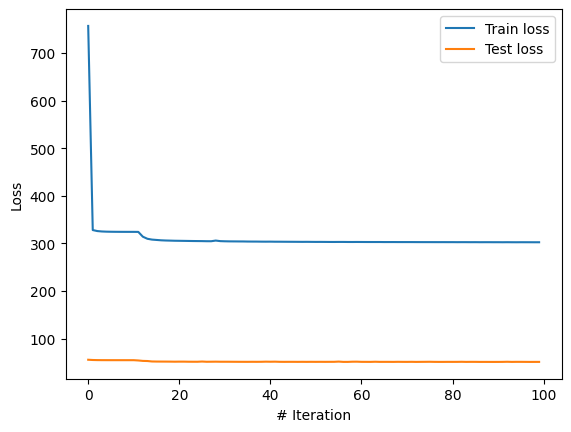

(<matplotlib.legend.Legend at 0x798120110d60>,
 Text(0.5, 24.0, '# Iteration'),
 Text(24.000000000000007, 0.5, 'Loss'),
 None)

In [52]:
iteration = np.arange(NUM_EPOCHS)
plt.plot(iteration, train_loss, label="Train loss"), plt.plot(iteration, test_loss, label="Test loss"),
plt.legend(), plt.xlabel("# Iteration"), plt.ylabel("Loss"), plt.show()

# Apply SVM classifier Part

First let's load the model

In [16]:
# Create an instance of your VAE model
model = VAE()

# Load the trained weights from the file (assuming it's a state_dict)
weights_path = 'VAE_weights.pth'
device = torch.device(device)  # Set device to CPU
model.load_state_dict(torch.load(weights_path, map_location=device))

# Move the loaded model to the CPU
model.to(device)

VAE(
  (down_1): DownBlock(
    (model): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (down_2): DownBlock(
    (model): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (to_vec): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): ReLU()
  )
  (embed): Sequential(
    (0): Linear(in_features=1600, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
  )
  (mu_fc): Linear(in_features=500, out_features=100, bias=True)
  (logvar_fc): Linear(in_features=

In [15]:
def extract_features(loader):
    features = []
    labels = []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            # Forward pass through the encoder part of the VAE
            x = model.down_1(data)
            x = model.down_2(x)
            x = model.to_vec(x)
            x = model.embed(x)
            # Extract mu and log_var from the latent space
            mu = model.mu_fc(x)
            log_var = model.logvar_fc(x)
            # Concatenate mu and log_var as features
            features.append(torch.cat((mu, log_var), dim=1).cpu().numpy())
            labels.append(target.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels)
    return features, labels

In [18]:
def Train_SVM(num_samples, train_data, test_data):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=num_samples, shuffle=True)
    train_features, train_labels = extract_features(train_loader)
    # Train an SVM classifier
    svm_classifier = svm.SVC(kernel='rbf')
    svm_classifier.fit(train_features, train_labels)

    # Test the SVM classifier
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=False)
    test_features, test_labels = extract_features(test_loader)
    predicted_labels = svm_classifier.predict(test_features)
    accuracy = accuracy_score(test_labels, predicted_labels)
    print("Accuracy:", accuracy)
    return svm_classifier, accuracy

In [19]:
# Load Fashion MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST('F_MNIST_data', download=down_flag, train=True, transform=transform)
test_data = datasets.FashionMNIST('F_MNIST_data', download=down_flag, train=False, transform=transform)

svm100, acc_100 = Train_SVM(100, train_data, test_data)
svm_600, acc_600 = Train_SVM(600, train_data, test_data)
svm_1000, acc_1000 = Train_SVM(1000, train_data, test_data)
svm_3000, acc_3000 = Train_SVM(3000, train_data, test_data)

Accuracy: 0.8091
Accuracy: 0.8127
Accuracy: 0.8131
Accuracy: 0.8139


Save results

In [20]:
from joblib import dump, load

# Assuming svm is your trained SVM model
dump(svm100, 'svm_model(100).joblib')
dump(svm_600, 'svm_model(600).joblib')
dump(svm_1000, 'svm_model(1000).joblib')
dump(svm_3000, 'svm_model(3000).joblib')

['svm_model(3000).joblib']

# Test Results

First Let's Load NN model ans SVM model

In [10]:
# Create an instance of your VAE model
model = VAE()

# Load the trained weights from the file (assuming it's a state_dict)
weights_path = 'VAE_weights.pth'
device = torch.device(device)  # Set device to CPU
model.load_state_dict(torch.load(weights_path, map_location=device))

# Move the loaded model to the CPU
model.to(device)

VAE(
  (down_1): DownBlock(
    (model): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (down_2): DownBlock(
    (model): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (to_vec): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): ReLU()
  )
  (embed): Sequential(
    (0): Linear(in_features=1600, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
  )
  (mu_fc): Linear(in_features=500, out_features=100, bias=True)
  (logvar_fc): Linear(in_features=

In [13]:
from joblib import load

svm_100 = load('svm_model(100).joblib')
svm_600 = load('svm_model(600).joblib')
svm_1000 = load('svm_model(1000).joblib')
svm_3000 = load('svm_model(3000).joblib')

In [16]:
def Test_results(svm_classifier, test_data):
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=False)
    test_features, test_labels = extract_features(test_loader)
    predicted_labels = svm_classifier.predict(test_features)
    error_rate = 1 - accuracy_score(test_labels, predicted_labels)
    return error_rate

In [17]:
error_rate_100 = Test_results(svm_100, test_data)
error_rate_600 = Test_results(svm_600, test_data)
error_rate_1000 = Test_results(svm_1000, test_data)
error_rate_3000 = Test_results(svm_3000, test_data)

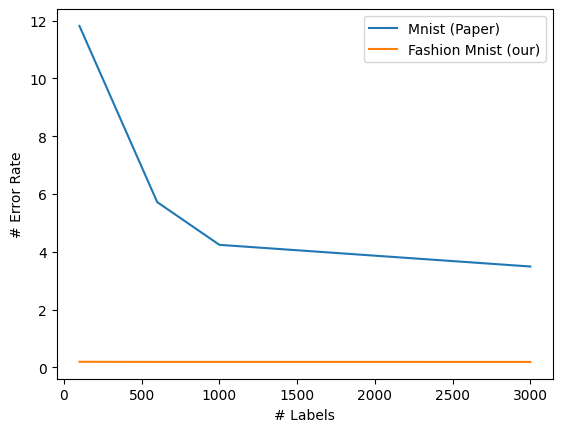

(Text(0.5, 24.0, '# Labels'),
 Text(24.000000000000007, 0.5, '# Error Rate'),
 None)

In [19]:
# Plot Final Results
num_class = [100, 600, 1000, 3000]
my_results = [error_rate_100, error_rate_600, error_rate_1000, error_rate_3000]
papper_results = [11.82, 5.72, 4.24, 3.49]

plt.plot(num_class, papper_results, label="Mnist (Paper)")
plt.plot(num_class, my_results, label="Fashion Mnist (our)")
plt.legend()
plt.xlabel("# Labels"), plt.ylabel("# Error Rate"), plt.show()